In [ ]:
# Imports
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import datetime as dt

from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error,mean_squared_log_error ,mean_absolute_percentage_error , accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, RandomizedSearchCV

In [ ]:
#######################################################
############### If using Google Drive #################
#######################################################

# Please note that if this cell does not run go to where the shared folder is on Google Drive, and
# right-click on the shared folder, and select Add shortcut to Drive. Then try execute the cell again.

# Mount Google Drive where datasets are located
from google.colab import drive
drive.mount('/content/gdrive')

# Change the current working directory
%cd /content/gdrive/MyDrive/DS\ Capstone\ Project/REPORT_CODE_STRUCTURED/data/

# Define data path
data_path = "processed/"

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/107U69c8Nh3fH_vc0lG1KAZi0i92sHvcb/DS Capstone Project/REPORT_CODE_STRUCTURED/data


In [ ]:
#######################################################
############## If using Local Computer ################
#######################################################

# Define data path
data_path = "../data/processed/"

In [ ]:
# Import cleaned data
df = pd.read_csv(f'{data_path}data_used_to_build_model.csv')

# Imports and functions

In [ ]:
# Define function to calc evaluation metrics
def calc_evaluation_metrics(y_pred, y, set_desc):
  # Evaluation metrics
  mse = mean_squared_error(y, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y, y_pred)
  mape = mean_absolute_percentage_error(y, y_pred)
  r2 = r2_score(y, y_pred)
  accuracy = (1 - mape) * 100

  # Calculate and display accuracy
  print("=================================")
  print("Evaluation Metrics of " + set_desc)
  print("Mean Squared Error : {0:7.8f}".format(mse))
  print("Root Mean Squared Error : {0:7.8f}".format(rmse))
  print("Mean Absolute Error : {0:7.8f}".format(mae))
  print("Mean Absolute Percentage Error : {0:7.8f}".format(mape))
  print(f"R-Squared : {round(r2, 4)}%")
  print(f"Accuracy: {round(accuracy, 4)}%.")
  print("=================================")

  return mse, rmse, mae, mape, r2, accuracy

## Shift target feature (total demand) 
shift target features so that each row is predicting demand in future. A number of different time offsets are tested

In [ ]:
# Select one state
df = df[df["REGIONID"] == "QLD"]
state="QLD"

df = df.drop(["REGIONID"], axis=1)

# convert to datetime
df["DATETIME"] = pd.to_datetime(df["DATETIME"])

# Create date features

df["Hour"] = df["DATETIME"].dt.hour
df["Day"] = df["DATETIME"].dt.dayofweek
df["Month"] = df["DATETIME"].dt.month
df["Year"] = df["DATETIME"].dt.year
df["Qtr"] = df["DATETIME"].dt.quarter
df["Dayofyear"] = df["DATETIME"].dt.dayofyear
df["Dayofmonth"] = df["DATETIME"].dt.day
df["Weekofyear"] = df["DATETIME"].dt.weekofyear

df["temp_date"] = df["DATETIME"].dt.strftime("%m-%d")
df["temp_date2"] = df["DATETIME"].dt.strftime("%m-%d-%y")

# Set datetime as index
df.index = df["DATETIME"]

# Create feature to denote "Current Demand"
df["CURRENTDEMAND"] = df["TOTALDEMAND"]

#Shift hours for timeseries
df["TOTALDEMAND_30"] = df["CURRENTDEMAND"].shift(-1) # Shift by 30 mins
df["TOTALDEMAND_60"] = df["CURRENTDEMAND"].shift(-2) # Shift by 1 hour
df["TOTALDEMAND_90"] = df["CURRENTDEMAND"].shift(-3) # Shift by 2 hours
df["TOTALDEMAND_120"] = df["CURRENTDEMAND"].shift(-4) # Shift by 3 hours
df["TOTALDEMAND_150"] = df["CURRENTDEMAND"].shift(-5) # Shift by 4 hours
df["TOTALDEMAND_180"] = df["CURRENTDEMAND"].shift(-6) # Shift by 6 hours

# Drop last row with null (due to shift)
df = df.dropna()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


## Feature engineering
Add dates of public holidays weekend

In [ ]:

  # Create feature for weekend 
def feature_weekend(row):
    if row["Day"] == 5 or row["Day"] == 6:
        return "Weekend"
    return "NonWeekend"

# Apply feature eng
df["Weekend"] = df.apply(lambda row: feature_weekend(row), axis=1)

# One-hot encode categorical fields
dummies = pd.get_dummies(df[["Weekend"]], prefix="is", drop_first=True)
df = df.join(dummies, lsuffix="_left")
df = df.drop(df[["Weekend"]], axis=1)

# drop temporary fields
df = df.drop(["temp_date"], axis=1)
df = df.drop(["temp_date2"], axis=1)

## Split into 3 dataframes corresponding to train test periods

In [ ]:
# Define model start time and train/test cutoff time
model_start_time = '2016-01-01 00:00:00'
trainTestSplit = '2020-01-01 00:00:00'

df = df[df['DATETIME'] >= model_start_time] # using dataset from 2016 onward
# We also make a further 2 DataFrames for Cross Validation
### First we define the endtimes for train/val/test splits
train_end_1618, val_end_1618, test_end_1618 = '2016-12-31 23:30:00', '2017-12-31 23:30:00', '2018-12-31 23:30:00'
train_end_1619, val_end_1619, test_end_1619 = '2017-12-31 23:30:00', '2018-12-31 23:30:00', '2019-12-31 23:30:00'
train_end_1620, val_end_1620, test_end_1620 = '2018-12-31 23:30:00', '2019-12-31 23:30:00', '2020-12-31 23:30:00'

#train_end_1620, val_end_1620, test_end_1620 = '2018-12-31 23:30:00', '2019-12-31 23:30:00', '2021-03-18 00:00:00'# not using due to inconsistent holdout set length
### Define the 3 CV DataFrames
df_1618 = df.loc[(model_start_time <= df['DATETIME']) & (df['DATETIME'] <= test_end_1618), :].copy()
df_1619 = df.loc[(model_start_time <= df['DATETIME']) & (df['DATETIME'] <= test_end_1619), :].copy()
df_1620 = df.loc[(model_start_time <= df['DATETIME']) & (df['DATETIME'] <= test_end_1620), :].copy()


# Split into train test based ib "train end" val defined above

# 16-18 period
df_train_1618 = df_1618[df_1618["DATETIME"]  <= train_end_1618].copy()
df_test_1618 = df_1618[(df_1618["DATETIME"] > train_end_1618) & (df_1618["DATETIME"] <= val_end_1618)].copy()
df_holdout_1618 = df_1618[(df_1618["DATETIME"] > val_end_1618) & (df_1618["DATETIME"] <= test_end_1618)].copy()

# 16-19 period
df_train_1619 = df_1619[df_1619["DATETIME"] <= train_end_1619].copy()
df_test_1619 = df_1619[(df_1619["DATETIME"] > train_end_1619) & (df_1619["DATETIME"] <= val_end_1619) ].copy()
df_holdout_1619 = df_1619[(df_1619["DATETIME"] > val_end_1619) & (df_1619["DATETIME"] <= test_end_1619)].copy()

# 16-20 period
df_train_1620 = df_1620[df_1620["DATETIME"] <= train_end_1620].copy()
df_test_1620 = df_1620[(df_1620["DATETIME"] > train_end_1620) & (df_1620["DATETIME"] <= val_end_1620)].copy()
df_holdout_1620 = df_1620[(df_1620["DATETIME"] > val_end_1620) & (df_1620["DATETIME"] <= test_end_1620)].copy()



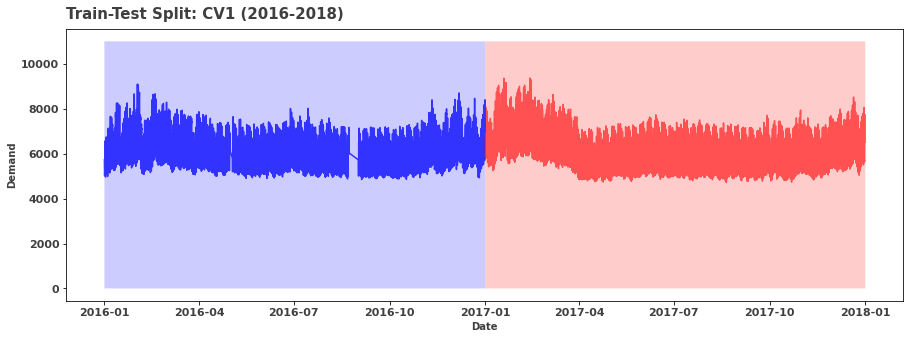

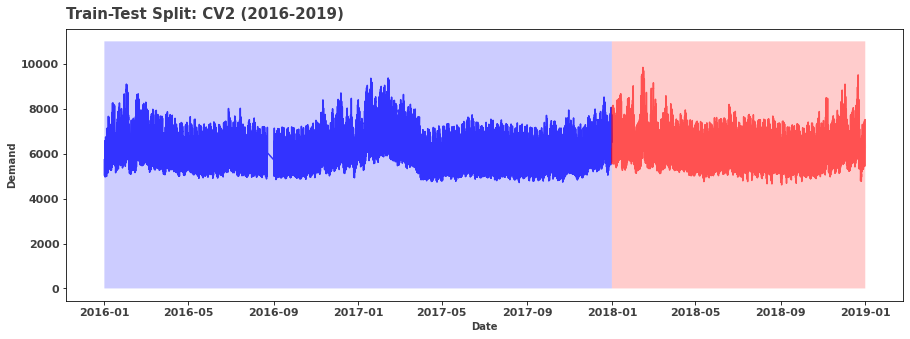

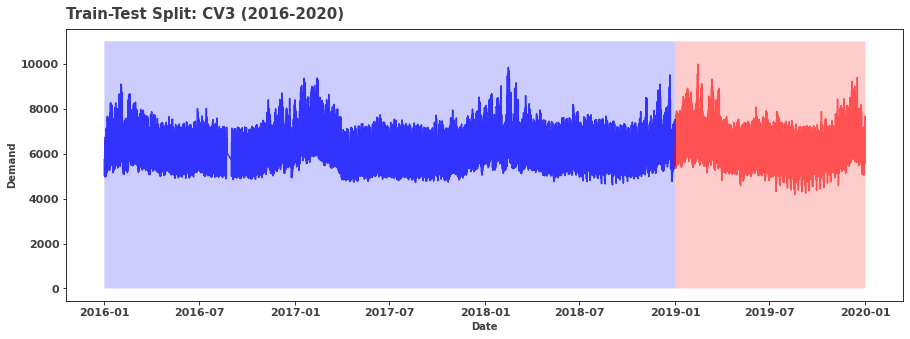

In [ ]:
# Plot train test split

def plot_train_test_split(train, test, title):
  fig,ax = plt.subplots(figsize=(15,5))
  coloring = 11000
  plt.plot(train.index, train["TOTALDEMAND"],color="blue", alpha=0.75)
  plt.fill_between(train.index,coloring, facecolor="blue", alpha=0.2)

  plt.plot(test.index, test["TOTALDEMAND"], color = "red", alpha=0.60)
  plt.fill_between(test.index,coloring, facecolor="red", alpha=0.2)

  plt.xlabel("Date", alpha=0.75, weight="bold")
  plt.ylabel("Demand", alpha=0.75, weight="bold")
  plt.xticks(alpha=0.75,weight="bold", fontsize=11)
  plt.yticks(alpha=0.75,weight="bold", fontsize=11)
  plt.title(title, alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

plot_train_test_split(df_train_1618, df_test_1618, "Train-Test Split: CV1 (2016-2018)") # 16-18
plot_train_test_split(df_train_1619, df_test_1619, "Train-Test Split: CV2 (2016-2019)") # 16-19
plot_train_test_split(df_train_1620, df_test_1620, "Train-Test Split: CV3 (2016-2020)") # 16-20

# Drop unnecessary cols in preparation for input to model
def drop_unnecessary_cols(df_train, df_test, df_holdout):
  df_train = df_train.drop(["DATETIME"], axis=1)
  df_test = df_test.drop(["DATETIME"], axis=1)
  df_holdout = df_holdout.drop(["DATETIME"], axis=1)
  return df_train, df_test, df_holdout

df_train_1618, df_test_1618, df_holdout_1618 = drop_unnecessary_cols(df_train_1618, df_test_1618, df_holdout_1618)
df_train_1619, df_test_1619, df_holdout_1619 = drop_unnecessary_cols(df_train_1619, df_test_1619, df_holdout_1619)
df_train_1620, df_test_1620, df_holdout_1620 = drop_unnecessary_cols(df_train_1620, df_test_1620, df_holdout_1620)

In [ ]:
def prepare_Xy(df):
  # Feature frame (Drop demand column) and Target frame (only demand column)
  X = df.drop(["TOTALDEMAND", "TOTALDEMAND_30", "TOTALDEMAND_60", "TOTALDEMAND_90", "TOTALDEMAND_120", "TOTALDEMAND_150", "TOTALDEMAND_180"], axis=1)
  y = df[["TOTALDEMAND_30", "TOTALDEMAND_60", "TOTALDEMAND_90", "TOTALDEMAND_120", "TOTALDEMAND_150", "TOTALDEMAND_180"]]
  return X, y

# Set up train and test sets
X_train, y_train = prepare_Xy(df_train_1620)
X_test, y_test = prepare_Xy(df_test_1620)

# Run model for all 2 CrossValidation sets and calculate evaluation metrics:


In [ ]:
# Model settings:
rf_Reg_tuned = RandomForestRegressor(n_estimators = 1000, 
                           max_depth = 20, 
                           max_features= 'log2', 
                           n_jobs = -1,
                           #min_samples_leaf = 15,
                           random_state = 42, 
                           #max_leaf_nodes = 15, 
                           bootstrap = False)


# Define function to train model on one fold and calculate required evaluation metrics
def train_cv(reg_multi, df_train, df_test, verb):

  # Set up features and target
  X_train, y_train = prepare_Xy(df_train)
  X_test,  y_test = prepare_Xy(df_test)
  # replace nan values with 0
  X_train.fillna(0, inplace=True)
  X_test.fillna(0, inplace=True)

  # fit multi output regressor
  reg_multi.fit(X_train, y_train)

  # make predictions on test set
  y_pred = reg_multi.predict(X_test)

  # calculate evaluation metrics
  mse, rmse, mae, mape, r2, acc = calc_evaluation_metrics(y_pred, y_test, "Test Set")
  d = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R-Squared': r2, 'Accuracy': acc}
  metrics = pd.Series(data=d)

  return reg_multi, metrics

In [ ]:
# Train and evaluate model on the two CV folds. We dont use 2016-2019
# 2016-2018
rf_multi_1618 = MultiOutputRegressor(rf_Reg_tuned)
rf_Reg_1618, metrics_1618 = train_cv(rf_multi_1618, df_train_1618, df_test_1618, verb=False)

# 2016-2020
rf_multi_1620 = MultiOutputRegressor(rf_Reg_tuned)
rf_Reg_1620, metrics_1620  = train_cv(rf_multi_1620, df_train_1620, df_test_1620, verb=False)

# 2016-2019 ( we dont use it as it overlapsed)
#rf_multi_1619 = MultiOutputRegressor(rf_Reg_tuned)
#rf_Reg_1619, metrics_1619  = train_cv(rf_multi_1619, df_train_1619, df_test_1619, verb=False)

In [ ]:
# Combine metrics into dataframe
df_metrics = pd.concat([metrics_1618, metrics_1620], axis=1)

# calculate mean metrics:
print("Average metrics for 2 folds")
df_metrics.mean(axis=1)

In [ ]:
# Define function to calculate metrics on holdout set
def evaluate_holdout(model, df_holdout):
  X_holdout, y_holdout = prepare_Xy(df_holdout)
  y_pred = model.predict(X_holdout)
  mse, rmse, mae, mape, r2, acc = calc_evaluation_metrics(y_pred, y_holdout, "Holdout Set")
  d = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R-Squared': r2, 'Accuracy': acc}
  metrics = pd.Series(data=d)
  return metrics, y_pred

# Calculate metrics on holdout / final test set for the three CV folds
metrics_1618, y_pred_1618 = evaluate_holdout(rf_Reg_1618, df_holdout_1618)
metrics_1620, y_pred_1620 = evaluate_holdout(rf_Reg_1620, df_holdout_1620)
#metrics_1619, y_pred_1619 = evaluate_holdout(rf_Reg_1619, df_holdout_1619) # We dont use 2016-2019 as this is overlapse

# Combine metrics into dataframe
df_metrics = pd.concat([metrics_1618, metrics_1620], axis=1)

# calculate mean metrics:
print("============================================")
print("Average metrics for 2 folds")
df_metrics.mean(axis=1)

# Plot predictions against actuals

In [ ]:
# Plot predictions against actuals

def plot_single_prediction(actual, predicted, title):
  fig, ax= plt.subplots(figsize=(15,5))

  ax.plot(actual.index, actual["TOTALDEMAND"], color ="red" , label="Actual")
  ax.plot(actual.index, predicted, alpha=.5, color = "yellow", label="Predicted")
  plt.xlabel("Date", alpha=0.75, weight="bold")
  plt.ylabel("Demand", alpha=0.75, weight="bold")
  plt.xticks(alpha=0.75,weight="bold", fontsize=11)
  plt.yticks(alpha=0.75,weight="bold", fontsize=11)
  plt.title(title, alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")
  plt.legend()

def plot_predictions(model, demand_train, demand_test, y_pred, title):
  plot_single_prediction(demand_test, y_pred[:,0], title + str(" (t+30 prediction)"))
  plot_single_prediction(demand_test, y_pred[:,0], title + str(" (t+60 prediction"))
  plot_single_prediction(demand_test, y_pred[:,0], title + str(" (t+90 prediction"))
  plot_single_prediction(demand_test, y_pred[:,0], title + str(" (t+120 prediction"))
  plot_single_prediction(demand_test, y_pred[:,0], title + str(" (t+150 prediction"))
  plot_single_prediction(demand_test, y_pred[:,0], title + str(" (t+180 prediction"))

# Plot predictions for the three years
plot_predictions(rf_Reg_1620, df_train_1620, df_holdout_1620, y_pred_1620, "Predicted vs Actual Demand 16-20")


# Look at worst and best periods of time

# Best and worst predictions

In [ ]:
# Plot Worst Hour Prediction for t+30 prediction

# Worst Hour Prediction for t+30 predicion only
df_holdout_1620["Difference"] = np.abs(df_holdout_1620["TOTALDEMAND"] - y_pred_1620[:,0])
df_holdout_1620["Difference"].sort_values(ascending=False)[:10]
def plot_specific_period(df_holdout, y_pred, t, date_start, date_end):
  fig, ax= plt.subplots(figsize=(15,5))

  ax.plot(df_holdout.index, df_holdout["TOTALDEMAND"], label="Actual")
  ax.plot(df_holdout.index, y_pred[:,t],alpha=.5,color ="red",label="Predicted")

  demand = df_holdout["TOTALDEMAND"]
  pred = y_pred[:,0]

  plt.fill_between(df_holdout.index, demand, pred, facecolor="green", alpha=.2, label="Difference")

  # Set axes to look at specified interval

  #ax.set_ylim()
  ax.set_xbound(lower=date_start, upper=date_end)

  plt.xlabel("Date", alpha=0.75, weight="bold")
  plt.ylabel("Demand", alpha=0.75, weight="bold")

  plt.xticks(alpha=0.75,weight="bold", fontsize=11)
  plt.yticks(alpha=0.75,weight="bold", fontsize=11)

  plt.title("Period with the worst hourly prediction", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")
  plt.legend()

plot_specific_period(df_holdout_1620, y_pred_1620, 0, datetime.date(2020, 9, 26), datetime.date(2020, 9, 28))
plot_specific_period(df_holdout_1620, y_pred_1620, 0, datetime.date(2020, 10, 3), datetime.date(2020, 10, 5))
plot_specific_period(df_holdout_1620, y_pred_1620, 0, datetime.date(2020, 8, 22), datetime.date(2020, 8, 24))


In [ ]:
# Plot best days prediction

# Worst Days
worst_days = df_holdout_1620.groupby(['Year',"Month",'Dayofmonth']).mean()[['TOTALDEMAND', 'Difference']]
worst_days.sort_values(by="Difference", ascending=False)[:10]
# Best Days
worst_days.sort_values(by="Difference",ascending=True)[:10]
# Plot best days
plot_specific_period(df_holdout_1620, y_pred_1620, 0, datetime.date(2020, 10, 24), datetime.date(2020, 10, 25))
plot_specific_period(df_holdout_1620, y_pred_1620, 0, datetime.date(2020, 1, 1), datetime.date(2020, 1, 2))
plot_specific_period(df_holdout_1620, y_pred_1620, 0, datetime.date(2020, 12, 26), datetime.date(2020, 12, 27))
